In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import quantstats as qs
from filterpy.kalman import KalmanFilter

from quant.utils.cointegraion import do_adf_regression, do_aeg_regression
from quant.mean_reverting.stock_pair.positions import calculate_positions_from_zscore

# Константы
ticker1 = 'CFG'
ticker2 = 'TFC'

open_threshold = 0.75
close_threshold = 0.25

oneway_trans_cost=0.0005

tickers = pd.read_parquet('../../../../data/sp500_stocks.parquet')
tickers.set_index('ticker', inplace=True)

history = pd.read_parquet('../../../../data/sp500_2023-01-01_2025-01-01.parquet')['Adj Close']
live = pd.read_parquet('../../../../data/sp500_2025-01-01_2025-07-01.parquet')['Adj Close']

history = pd.concat([history, live], axis=0)

training_start_date = '2023-01-01'
training_end_date = '2024-01-01'
training_set = history[[ticker1, ticker2]].loc[training_start_date:training_end_date].copy()

sample_start_date = '2024-01-02'
sample_end_date = '2025-01-01'
sample_set = history[[ticker1, ticker2]].loc[sample_start_date:sample_end_date].copy()

out_of_sample_start_date = '2025-01-02'
out_of_sample_end_date = '2025-07-01'
out_of_sample_set = history[[ticker1, ticker2]].loc[out_of_sample_start_date:out_of_sample_end_date].copy()

### Отобразим цены

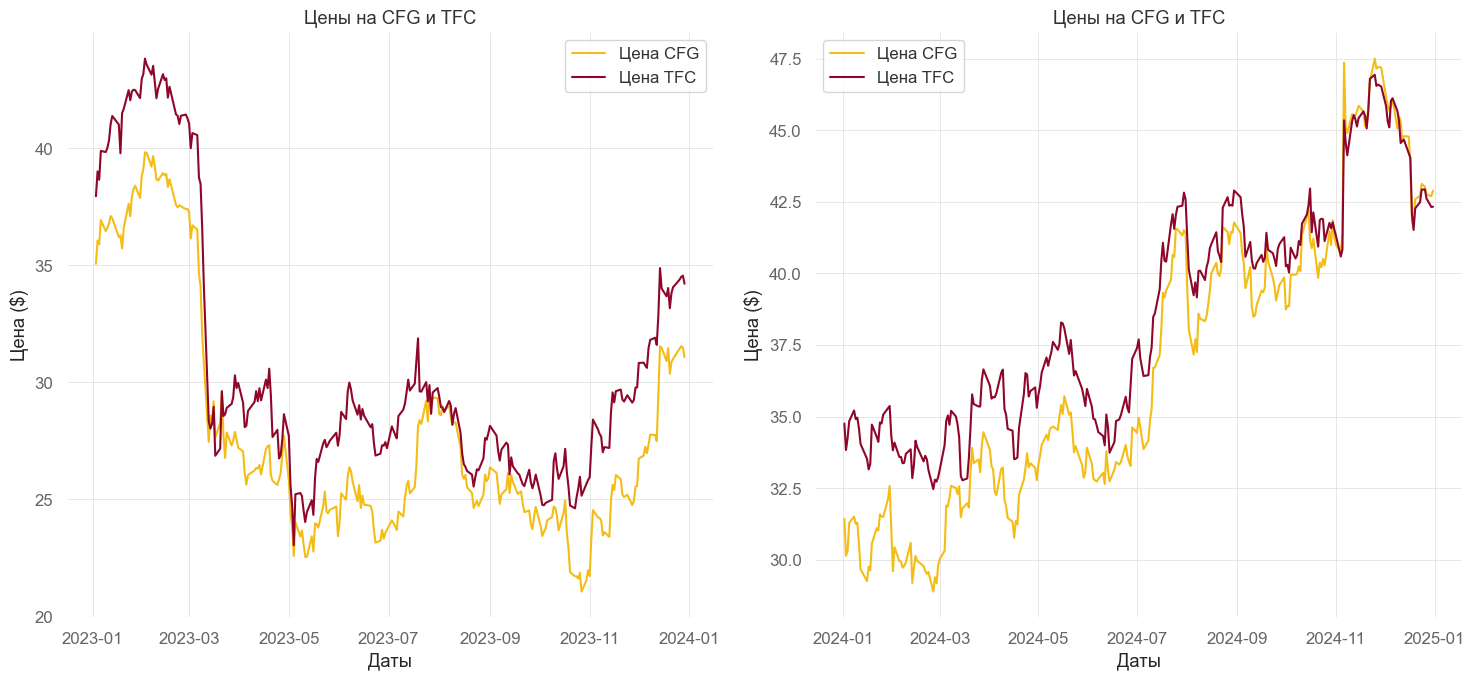

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].plot(training_set[ticker1], lw=1.5, label=f"Цена {ticker1}",color="#F4BD16")
axes[0].plot(training_set[ticker2], lw=1.5, label=f"Цена {ticker2}",color="#8E062A")
axes[0].grid(True)
axes[0].legend(loc=0)
axes[0].set_xlabel('Даты')
axes[0].set_ylabel('Цена ($)')
axes[0].set_title(f"Цены на {ticker1} и {ticker2}")

axes[1].plot(sample_set[ticker1], lw=1.5, label=f"Цена {ticker1}",color="#F4BD16")
axes[1].plot(sample_set[ticker2], lw=1.5, label=f"Цена {ticker2}",color="#8E062A")
axes[1].grid(True)
axes[1].legend(loc=0)
axes[1].set_xlabel('Даты')
axes[1].set_ylabel('Цена ($)')
axes[1].set_title(f"Цены на {ticker1} и {ticker2}")

plt.tight_layout()
plt.show()

### Проверим коинтеграцию цен
Для этого мы посчитаем корреляцию, коинтеграция по Augmented Dickey-Fuller и коинтеграция по Augmented Engle-Granger.

In [22]:
# Correlation
correlation_coef = np.corrcoef(training_set[ticker1], training_set[ticker2])[0, 1]
adf_probability = do_adf_regression(training_set, ticker1, ticker2)
aeg_probability = do_aeg_regression(training_set, ticker1, ticker2)

print(f"Корреляция между {ticker1} и {ticker2}: {correlation_coef:.2f}")
print(f"Вероятность коинтеграции по ADF: {adf_probability:.1f}")
print(f"Вероятность коинтеграции по AEG: {aeg_probability:.1f}")

sample_correlation_coef = np.corrcoef(sample_set[ticker1], sample_set[ticker2])[0, 1]
sample_adf_probability = do_adf_regression(sample_set, ticker1, ticker2)
sample_aeg_probability = do_aeg_regression(sample_set, ticker1, ticker2)

print(f"Sample: Корреляция между {ticker1} и {ticker2}: {sample_correlation_coef:.2f}")
print(f"Sample: Вероятность коинтеграции по ADF: {sample_adf_probability:.1f}")
print(f"Sample: Вероятность коинтеграции по AEG: {sample_aeg_probability:.1f}")

Корреляция между CFG и TFC: 0.97
Вероятность коинтеграции по ADF: 95.0
Вероятность коинтеграции по AEG: nan
Sample: Корреляция между CFG и TFC: 0.99
Sample: Вероятность коинтеграции по ADF: 99.0
Sample: Вероятность коинтеграции по AEG: 99.0


### Расчитаем окно для rolling window функции

In [23]:
# Calculate hedge ratio using OLS regression
training_hedge_ratio = sm.OLS(training_set[ticker1], training_set[ticker2]).fit().params
training_hedge_ratio.iloc[0]

# Calculate spread using the hedge ratio
training_spread = training_set[ticker1] - training_hedge_ratio.iloc[0] * training_set[ticker2]
lagged = training_spread.shift(1).dropna()
delta = training_spread.diff().dropna()

# Align the series
lagged = lagged.loc[delta.index]

# Regress delta on lagged
X = sm.add_constant(lagged)
model = sm.OLS(delta, X).fit()
beta = model.params.iloc[1]

# Calculate half-life
half_life = -np.log(2) / beta
print(f"Half-life: {round(half_life)} days")

window = round(half_life * 1.5)

Half-life: 11 days


### Посчитаем hedge ratio

TODO: описать как мы используем Kalman Filter для этого

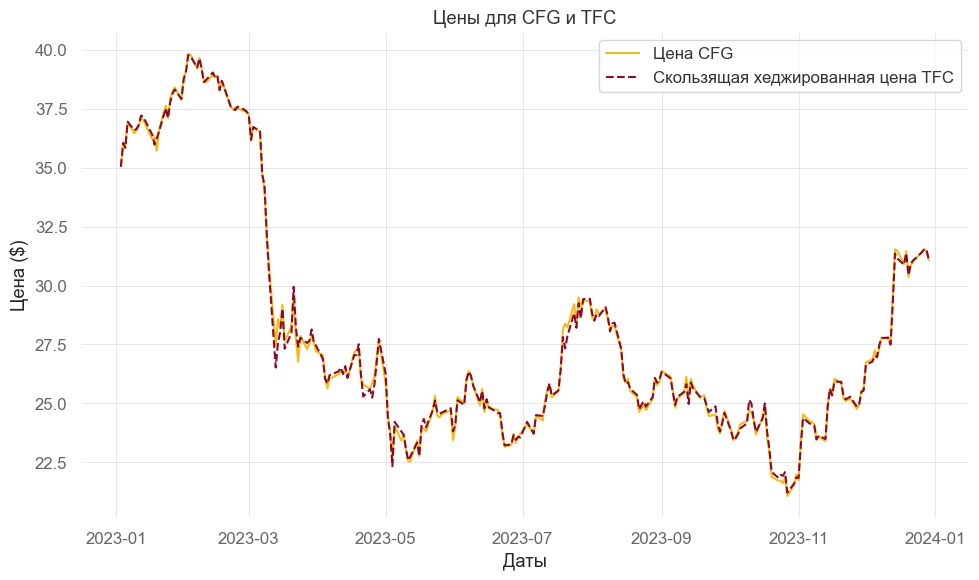

In [24]:
n = len(training_set[ticker1])
kf = KalmanFilter(dim_x=1, dim_z=1)

# Матричные параметры фильтра
kf.x = np.array([[0.]])           # начальное значение beta
kf.F = np.array([[1.]])           # матрица перехода
kf.H = np.array([[training_set[ticker2].iloc[0]]])  # матрица наблюдения (будет обновляться)
kf.P *= 1.0                       # ковариация начального состояния
kf.R *= 1.0                       # ковариация наблюдения
kf.Q *= 0.001                      # ковариация процесса

betas = []

def kalman_rolling_beta(row):
    x = row[ticker2]
    y = row[ticker1]
    kf.H = np.array([[x]])
    kf.predict()
    kf.update(y)

    return kf.x[0, 0]

hedge_ratio = training_set[[ticker1, ticker2]].apply(lambda row: kalman_rolling_beta(row), axis=1)

rolling_hedged_prices = hedge_ratio * training_set[ticker2]

plt.plot(training_set[ticker1], lw=1.5, label=f"Цена {ticker1}",color="#F4BD16")
plt.plot(rolling_hedged_prices, lw=1.5, linestyle='--', label=f"Скользящая хеджированная цена {ticker2}",color="#8E062A")
plt.xlabel('Даты')
plt.ylabel('Цена ($)')
plt.title(f"Цены для {ticker1} и {ticker2}")
plt.grid(True)
plt.legend(loc=0)

# This helps us tighten the figure margins
plt.tight_layout()
plt.show()

### Спред цен акций
Теперь посчитаем спреды и отобразим их вместе с арифметической средней и стандартным отклонением

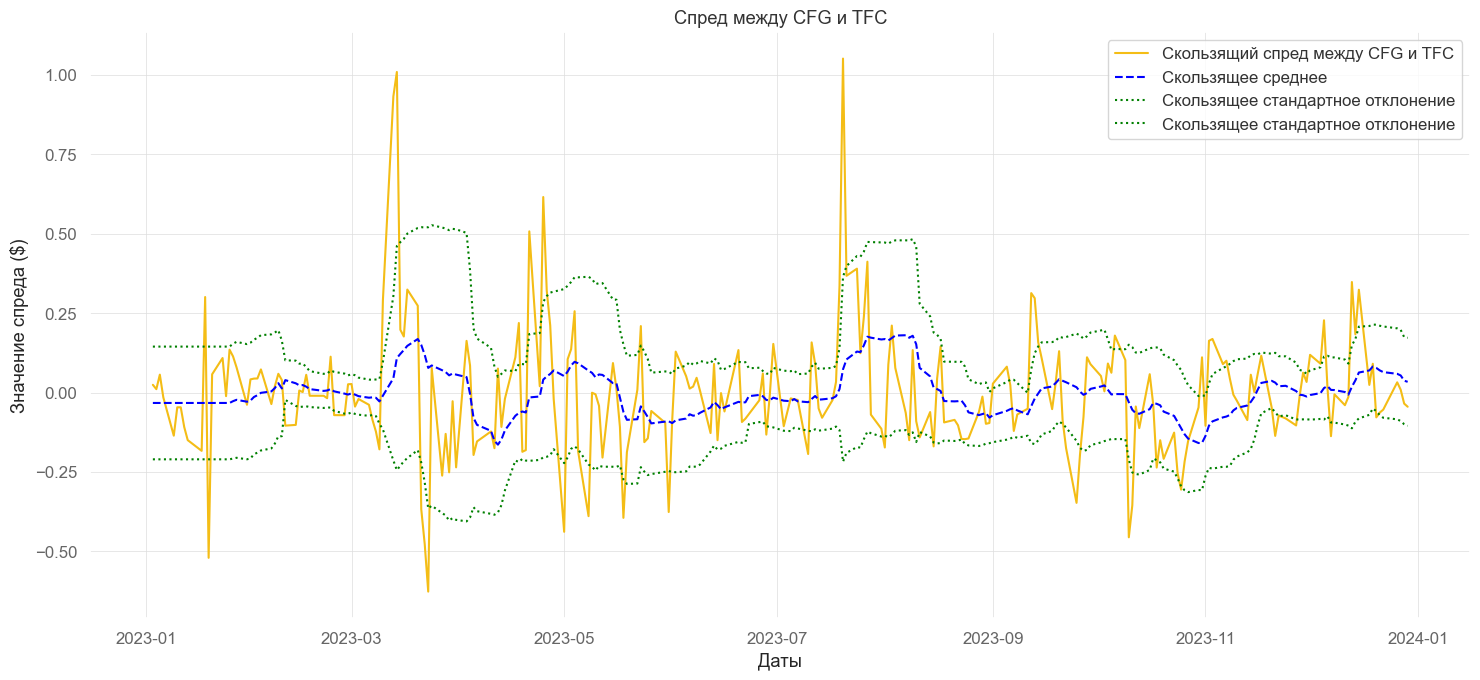

In [25]:
spread = training_set[ticker1] - hedge_ratio * training_set[ticker2]
rolling_spread_mean = spread.rolling(window).mean().bfill()
rolling_spread_std = spread.rolling(window).std().bfill()

plt.figure(figsize=(15, 7))
plt.plot(spread, lw=1.5, label=f"Скользящий спред между {ticker1} и {ticker2}",color="#F4BD16")
plt.plot(rolling_spread_mean, linestyle='--', label=f"Скользящее среднее", color='blue')
plt.plot(rolling_spread_mean + rolling_spread_std, linestyle=':', label=f"Скользящее стандартное отклонение", color='green')
plt.plot(rolling_spread_mean - rolling_spread_std, linestyle=':', label=f"Скользящее стандартное отклонение", color='green')
plt.xlabel('Даты')
plt.ylabel('Значение спреда ($)')
plt.title(f"Спред между {ticker1} и {ticker2}")
plt.grid(True)
plt.legend(loc=0)
plt.tight_layout()
plt.show()

### Z-score

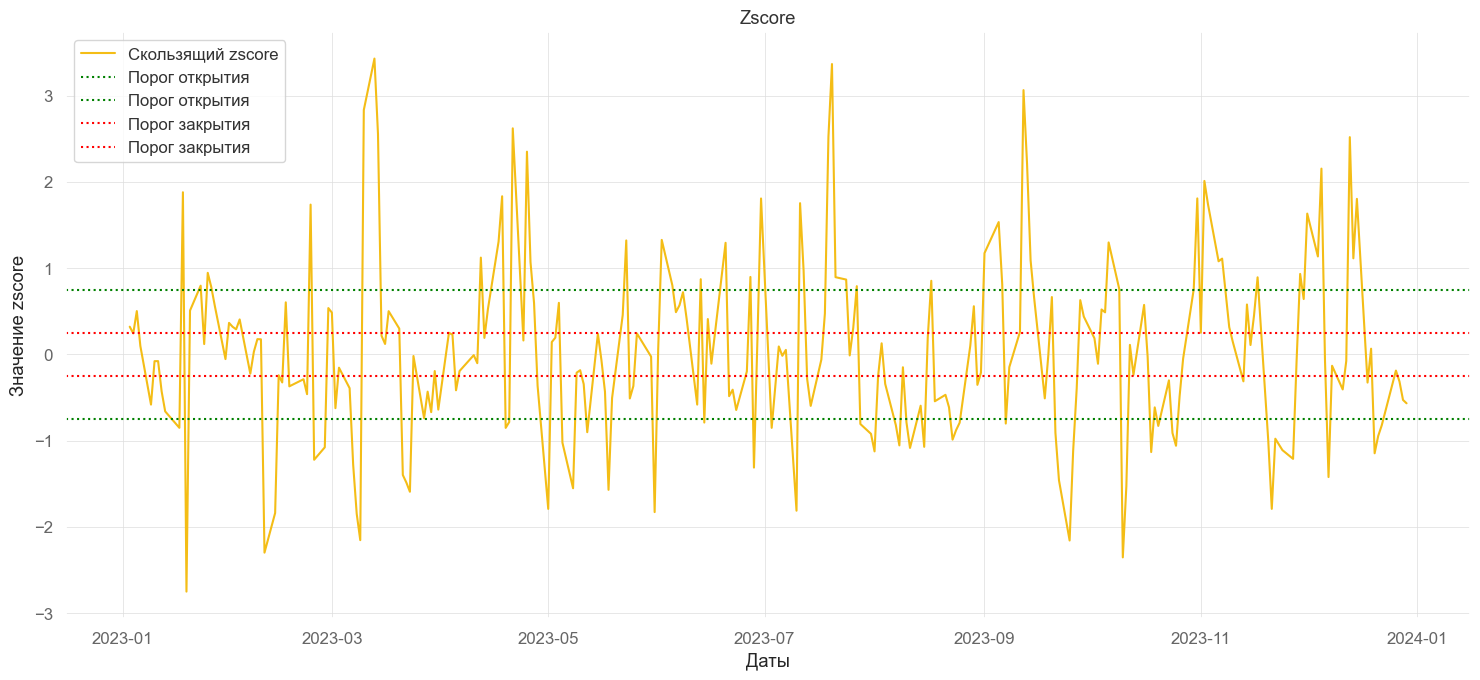

In [26]:
training_set['rolling_zscore'] = (spread - rolling_spread_mean) / rolling_spread_std

plt.figure(figsize=(15, 7))

plt.plot(training_set['rolling_zscore'], lw=1.5, label=f"Скользящий zscore",color="#F4BD16")
plt.axhline(y=open_threshold, color='green', linestyle=':', label="Порог открытия")
plt.axhline(y=-open_threshold, color='green', linestyle=':', label="Порог открытия")
plt.axhline(y=close_threshold, color='red', linestyle=':', label="Порог закрытия")
plt.axhline(y=-close_threshold, color='red', linestyle=':', label="Порог закрытия")
plt.xlabel('Даты')
plt.ylabel('Значение zscore')
plt.title(f"Zscore")
plt.grid(True)
plt.legend(loc=0)

# This helps us tighten the figure margins
plt.tight_layout()
plt.show()

# Позиции
Расчитаем когда будем открывать позиции, а когда закрывать.

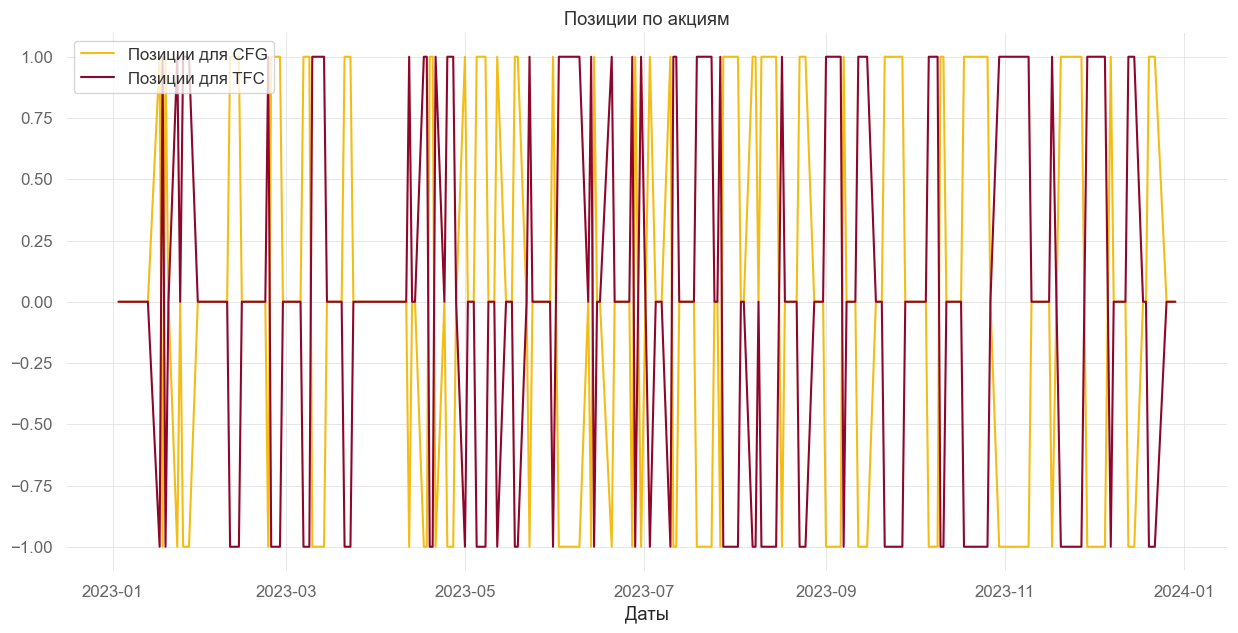

In [27]:
training_set['zscore'] = training_set['rolling_zscore']

positions_with_dates = calculate_positions_from_zscore(
    training_set,
    open_threshold,
    close_threshold
)

positions_with_dates = positions_with_dates.rename(columns={'ticker1': ticker1, 'ticker2': ticker2})

plt.figure(figsize=(15, 7))
plt.plot(positions_with_dates[ticker1], lw=1.5, label=f'Позиции для {ticker1}',color="#F4BD16")
plt.plot(positions_with_dates[ticker2], lw=1.5, label=f'Позиции для {ticker2}',color="#8E062A")
plt.grid(True)
plt.legend(loc=0)

# This helps us tighten the figure margins
plt.axis('tight')
plt.xlabel('Даты')
plt.title('Позиции по акциям')
plt.show()

### PnL
Посчитаем теперь Profits and Loss для нашей стратегии. У нас есть массив позиций, с датами. Но есть с ним небольшая проблема, расчет был произведен по цене закрытия и потому мы не можем учитывать доходы в эту дату, ведь фактически, мы открываем позицию на следующее утро. Чтобы это учесть мы выполним операцию сдвига, которые все данные в массиве подвинит на один день: `positions.shift()`

После этого, мы считаем измененение цены день ко дню и перемножаем результаты с позициями, получая массив в котором указано сколько мы заработали за день.

In [28]:
dailyret = training_set.loc[:, (ticker1, ticker2)].pct_change()
pnl = (np.array(positions_with_dates.shift()) * np.array(dailyret)).sum(axis=1)

pnl_with_dates = (positions_with_dates.shift() * dailyret).sum(axis=1)
sharpe_ration = np.sqrt(252) * pnl[1:].mean() / pnl[1:].std()
cummulative_pnl = np.cumprod(1 + pnl_with_dates) - 1
print(f"Sharpe Ratio: {sharpe_ration:.2f}")
print(f"Cummulative PnL: {cummulative_pnl.iloc[-1]:.2f}")

Sharpe Ratio: 0.23
Cummulative PnL: 0.03


                           Strategy
-------------------------  ----------
Start Period               2024-01-02
End Period                 2024-12-31
Risk-Free Rate             0.0%
Time in Market             57.0%

Cumulative Return          20.5%
CAGR﹪                     13.78%

Sharpe                     1.47
Prob. Sharpe Ratio         92.99%
Smart Sharpe               1.24
Sortino                    2.34
Smart Sortino              1.98
Sortino/√2                 1.65
Smart Sortino/√2           1.4
Omega                      1.39

Max Drawdown               -7.46%
Max DD Date                2024-10-07
Max DD Period Start        2024-06-20
Max DD Period End          2024-12-16
Longest DD Days            180
Volatility (ann.)          13.31%
Calmar                     1.85
Skew                       0.22
Kurtosis                   3.9

Expected Daily %           0.07%
Expected Monthly %         1.57%
Expected Yearly %          20.5%
Kelly Criterion            14.83%
Risk of Ruin     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-06-20,2024-10-07,2024-12-16,180,-7.455923,-7.259398
2,2024-02-01,2024-02-01,2024-02-12,12,-3.137236,-1.173072
3,2024-04-16,2024-04-17,2024-04-29,14,-2.906348,-2.671742
4,2024-03-14,2024-03-18,2024-03-18,5,-2.401966,-2.042929
5,2024-05-22,2024-06-10,2024-06-17,27,-2.126110,-1.882753


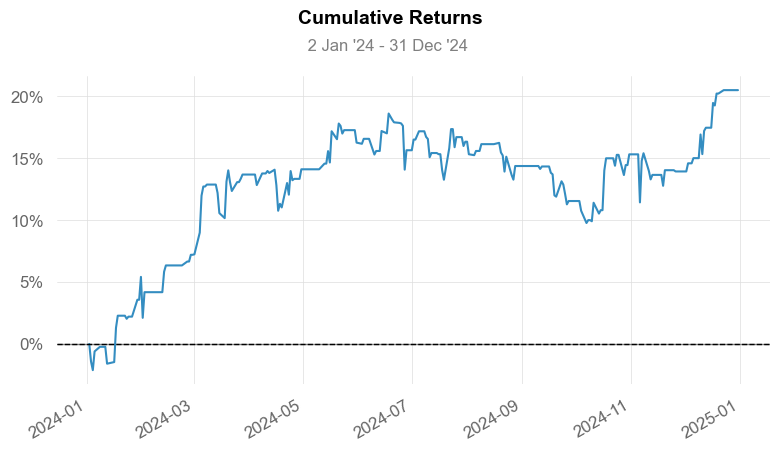

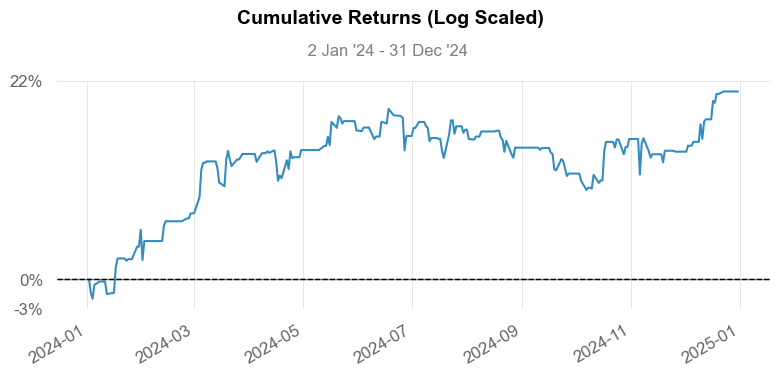

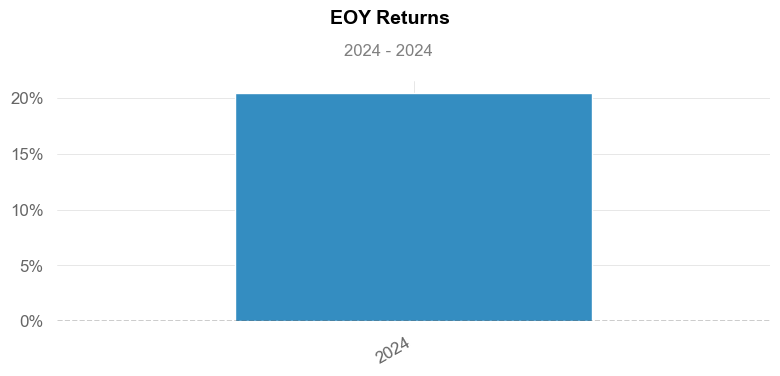

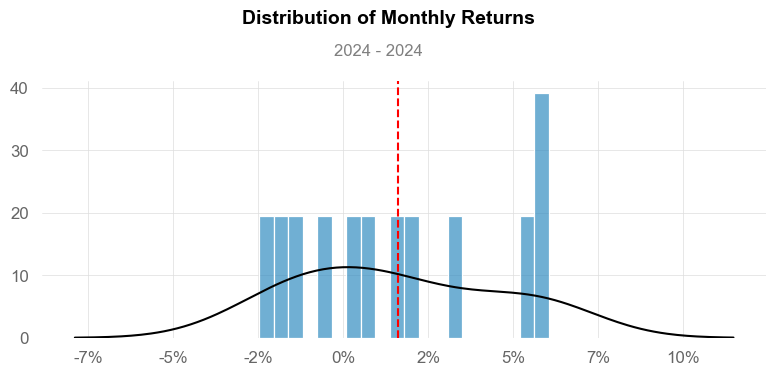

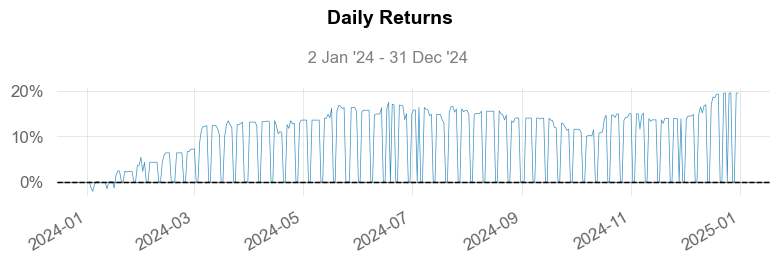

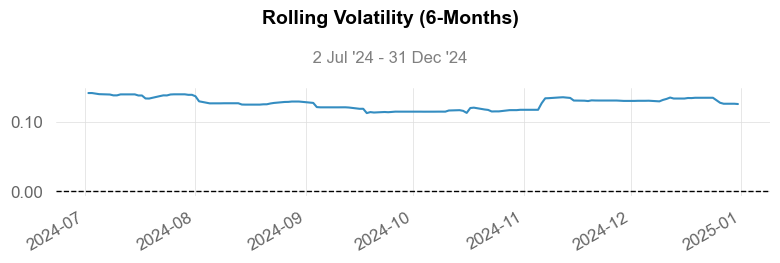

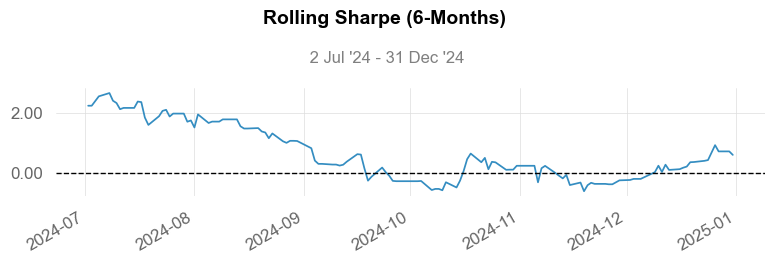

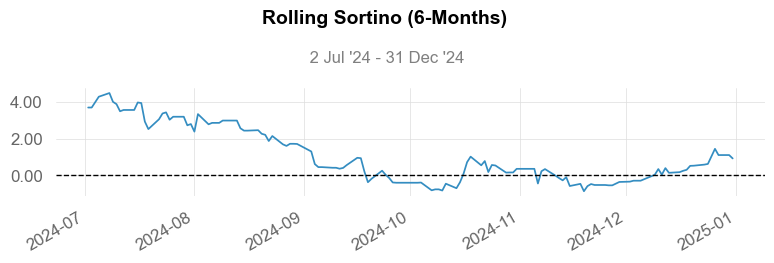

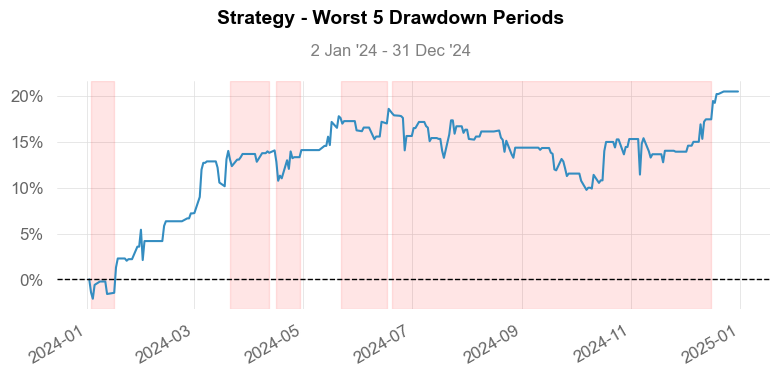

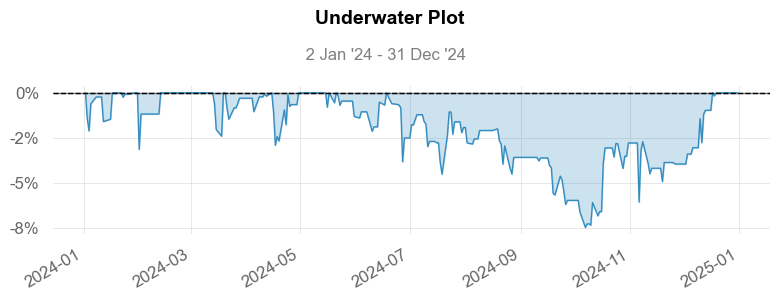

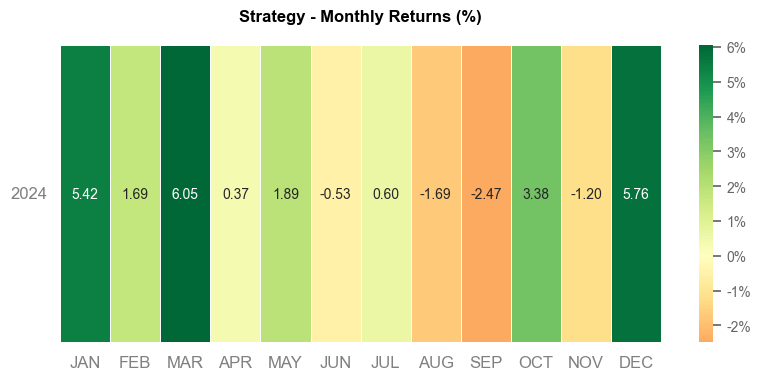

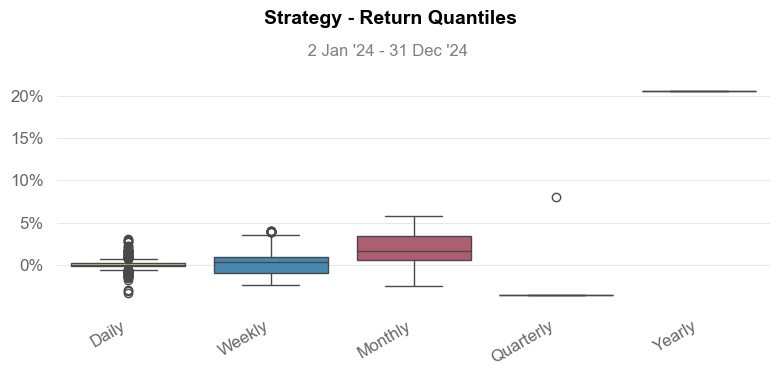

In [29]:
hedge_ratio = sample_set[[ticker1, ticker2]].apply(lambda row: kalman_rolling_beta(row), axis=1)

rolling_spread = sample_set[ticker1] - hedge_ratio * sample_set[ticker2]
rolling_spread_mean = rolling_spread.rolling(window=window).mean().bfill()
rolling_spread_std = rolling_spread.rolling(window=window).std().bfill()

sample_set['zscore'] = (rolling_spread - rolling_spread_mean) / rolling_spread_std

positions_with_dates = calculate_positions_from_zscore(
    sample_set,
    open_threshold,
    close_threshold
)

positions_with_dates = positions_with_dates.rename(columns={'ticker1': ticker1, 'ticker2': ticker2})

dailyret = sample_set.loc[:, (ticker1, ticker2)].pct_change()
pnl = (np.array(positions_with_dates.shift()) * np.array(dailyret)).sum(axis=1)

pnl_with_dates = (positions_with_dates.shift() * dailyret).sum(axis=1)

qs.reports.full(
    pnl_with_dates,
    title=f"Отчет по паре {ticker1} и {ticker2}",
)